# Libraries:

In [1]:
import os
import pandas as pd
import spotpy
import proplot as pplt
import shutil
import numpy as np
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import proplot as ppl

import sys
import json
import math
import re
import requests
import rasterio 
import seaborn as sns

# CAMELS Dataset: Daily from Daymet:

In [ ]:
BASE_DIR = r"F:\Data\CAMEL_SI\CAMELS_US\basin_mean_forcing\daymet"

EXPECTED_COLS = [
    "Year", "Mnth", "Day", "Hr",
    "dayl(s)", "prcp(mm/day)", "srad(W/m2)", "swe(mm)",
    "tmax(C)", "tmin(C)", "vp(Pa)"
]


def safe_float(s):
    s = str(s).strip()
    if s == "":
        return np.nan
    try:
        return float(s)
    except:
        return np.nan


def read_daymet_forcing_file(file_path):
    with open(file_path, "r") as f:
        lat  = safe_float(f.readline())
        elev = safe_float(f.readline())
        basin_id_in_file = f.readline().strip()

    df = pd.read_csv(
        file_path,
        sep=r"\s+",
        skiprows=3,
        engine="python",
        header=0,
        on_bad_lines="skip"
    )

    df.columns = [c.strip() for c in df.columns]

    if df.shape[1] < len(EXPECTED_COLS):
        return None

    df = df.iloc[:, :len(EXPECTED_COLS)]
    df.columns = EXPECTED_COLS

    for c in ["Year", "Mnth", "Day", "Hr"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.dropna(subset=["Year", "Mnth", "Day"])
    df = df[(df["Mnth"] >= 1) & (df["Mnth"] <= 12)]
    df = df[(df["Day"] >= 1) & (df["Day"] <= 31)]

    if df.empty:
        return None

    df["Year"] = df["Year"].astype(int)
    df["Mnth"] = df["Mnth"].astype(int)
    df["Day"]  = df["Day"].astype(int)
    df["Hr"]   = df["Hr"].fillna(12).astype(int)

    df["Date"] = pd.to_datetime(
        dict(year=df["Year"], month=df["Mnth"], day=df["Day"]),
        errors="coerce"
    )
    # df = df.dropna(subset=["Date"])

    if df.empty:
        return None

    forcing_cols = [c for c in EXPECTED_COLS if c not in ["Year", "Mnth", "Day", "Hr"]]
    for c in forcing_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    gauge_id = os.path.basename(file_path).split("_")[0]
    df.insert(0, "gauge_id", gauge_id)
    df["lat"] = lat
    df["elev"] = elev
    # df["basin_id_in_file"] = basin_id_in_file

    return df


def import_all_daymet_forcings(base_dir):
    all_data, skipped = [], 0

    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith(".txt") and "_forcing_" in file:
                full_path = os.path.join(root, file)

                try:
                    df = read_daymet_forcing_file(full_path)
                    if df is None or df.empty:
                        skipped += 1
                    else:
                        all_data.append(df)
                except:
                    skipped += 1

    forcing_all = pd.concat(all_data, ignore_index=True)
    forcing_all = forcing_all.sort_values(["gauge_id", "Date"]).reset_index(drop=True)

    return forcing_all

daymet_forcing_all = import_all_daymet_forcings(BASE_DIR)
cols = ['gauge_id',  'Date', 'prcp(mm/day)','srad(W/m2)', 'swe(mm)', 'tmax(C)', 'tmin(C)', 'vp(Pa)', 'lat','elev']
CAMELS_daymet_forcing_all = daymet_forcing_all[cols]

CAMELS_daymet_forcing_all

,gauge_id,Date,prcp(mm/day),srad(W/m2),swe(mm),tmax(C),tmin(C),vp(Pa),lat,elev
0,01013500,1980-01-01,0.00,153.40,0.0,-6.54,-16.30,171.69,46.84,353.0
1,01013500,1980-01-02,0.00,145.27,0.0,-6.18,-15.22,185.94,46.84,353.0
2,01013500,1980-01-03,0.00,146.96,0.0,-9.89,-18.86,138.39,46.84,353.0
3,01013500,1980-01-04,0.00,146.20,0.0,-10.98,-19.76,120.06,46.84,353.0
4,01013500,1980-01-05,0.00,170.43,0.0,-11.29,-22.21,117.87,46.84,353.0
...,...,...,...,...,...,...,...,...,...,...
2851395,13337000,1992-03-28,0.13,494.24,0.0,7.90,-6.52,381.16,46.61,1843.0
2851396,13337000,1992-03-29,0.00,507.95,0.0,9.39,-5.66,401.66,46.61,1843.0
2851397,13337000,1992-03-30,0.00,540.12,0.0,14.53,-2.72,497.04,46.61,1843.0
2851398,13337000,1992-03-31,0.00,528.44,0.0,15.37,-1.37,548.60,46.61,1843.0


In [25]:
daymet_longterm = (
    daymet_forcing_all
    .groupby("gauge_id", as_index=False)
    .agg(
        prcp_mean=("prcp(mm/day)", "mean"),
        srad_mean=("srad(W/m2)", "mean"),
        swe_mean=("swe(mm)", "mean"),
        tmax_mean=("tmax(C)", "mean"),
        tmin_mean=("tmin(C)", "mean"),
        vp_mean=("vp(Pa)", "mean"),
        lat=("lat", "first"),
        elev=("elev", "first"),
        n_days=("Date", "count")
    )
)

daymet_longterm


,gauge_id,prcp_mean,srad_mean,swe_mean,tmax_mean,tmin_mean,vp_mean,lat,elev,n_days
0,01013500,3.060050,298.238247,0.0,8.824959,-2.941887,654.987735,46.84,353.0,4443
1,01022500,3.562012,309.252552,0.0,11.692838,0.479793,779.370223,44.82,133.0,4444
2,01030500,3.151502,306.728778,0.0,10.703001,-1.332724,716.252582,45.80,170.0,4443
3,01031500,3.302457,313.325072,0.0,10.188482,-1.757755,697.208601,45.06,318.0,4441
4,01047000,3.173629,313.747301,0.0,10.123210,-2.157206,680.762116,44.98,613.0,4443
...,...,...,...,...,...,...,...,...,...,...
637,13235000,2.738824,408.053602,0.0,9.247244,-6.357136,378.493760,43.92,2696.0,4456
638,13240000,3.275883,404.792781,0.0,8.629322,-7.168720,376.040898,44.85,1779.0,4452
639,13310700,3.106390,396.070469,0.0,9.566365,-6.221741,398.309426,44.82,2190.0,4458
640,13313000,3.627378,421.925350,0.0,8.354475,-7.674160,364.153834,44.54,2189.0,4448


# Plot:

In [29]:
import io
r = requests.get("https://www.hydroshare.org/resource/658c359b8c83494aac0f58145b1b04e6/data/contents/camels_attributes_v2.0.feather")
attrs = gpd.read_feather(io.BytesIO(r.content))
r = requests.get("https://www.hydroshare.org/resource/658c359b8c83494aac0f58145b1b04e6/data/contents/camels_attrs_v2_streamflow_v1p2.nc")
attrs = attrs.reset_index(drop=False)


attrs["gauge_id"] = attrs["gauge_id"].astype(str).apply(lambda x: "0" + x if not x.startswith("0") else x)

daymet_longterm["gauge_id"] = daymet_longterm["gauge_id"].astype(str).apply(lambda x: "0" + x if not x.startswith("0") else x)
CAMELS_LongTerm_Final_vars_all = attrs.merge(daymet_longterm, on="gauge_id", how="inner")

# Drop duplicate columns (from merge)
cols_to_drop = [col for col in CAMELS_LongTerm_Final_vars_all.columns if col.endswith("_y")]
CAMELS_LongTerm_Final_vars_all = CAMELS_LongTerm_Final_vars_all.drop(columns=cols_to_drop)

# Rename columns back
CAMELS_LongTerm_Final_vars_all.columns = [col.replace("_x", "") for col in CAMELS_LongTerm_Final_vars_all.columns]

CAMELS_LongTerm_Final_vars_all

,gauge_id,huc_02,gauge_name,q_mean,runoff_ratio,slope_fdc,baseflow_index,stream_elas,q5,q95,...,geometry,prcp_mean,srad_mean,swe_mean,tmax_mean,tmin_mean,vp_mean,lat,elev,n_days
0,01013500,01,"Fish River Near Fort Kent, Maine",1.699155,0.543437,1.528219,0.585226,1.845324,0.241106,6.373021,...,"MULTIPOLYGON (((-68.3565 46.90311, -68.35612 4...",3.060050,298.238247,0.0,8.824959,-2.941887,654.987735,46.84,353.0,4443
1,01022500,01,"Narraguagus River At Cherryfield, Maine",2.173062,0.602269,1.776280,0.554478,1.702782,0.204734,7.123049,...,"POLYGON ((-67.97836 44.6131, -67.978 44.61303,...",3.562012,309.252552,0.0,11.692838,0.479793,779.370223,44.82,133.0,4444
2,01030500,01,"Mattawamkeag River Near Mattawamkeag, Maine",1.820108,0.555859,1.871110,0.508441,1.377505,0.107149,6.854887,...,"MULTIPOLYGON (((-67.83991 45.36614, -67.83954 ...",3.151502,306.728778,0.0,10.703001,-1.332724,716.252582,45.80,170.0,4443
3,01031500,01,"Piscataquis River Near Dover-Foxcroft, Maine",2.030242,0.576289,1.494019,0.445091,1.648693,0.111345,8.010503,...,"MULTIPOLYGON (((-69.3381 45.12316, -69.33799 4...",3.302457,313.325072,0.0,10.188482,-1.757755,697.208601,45.06,318.0,4441
4,01047000,01,"Carrabassett River Near North Anson, Maine",2.182870,0.656868,1.415939,0.473465,1.510238,0.196458,8.095148,...,"POLYGON ((-70.10847 45.21669, -70.10858 45.216...",3.173629,313.747301,0.0,10.123210,-2.157206,680.762116,44.98,613.0,4443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631,013235000,17,"Sf Payette River At Lowman, ID",1.659956,0.646655,1.062178,0.700849,1.298638,0.487956,5.783966,...,"POLYGON ((-115.34844 44.34929, -115.34836 44.3...",2.738824,408.053602,0.0,9.247244,-6.357136,378.493760,43.92,2696.0,4456
632,013240000,17,"Lake Fork Payette River Ab Jumbo Cr Nr Mccall, ID",2.579808,0.792020,0.915443,0.530890,1.273825,0.194838,12.956699,...,"POLYGON ((-115.96624 45.04092, -115.96587 45.0...",3.275883,404.792781,0.0,8.629322,-7.168720,376.040898,44.85,1779.0,4452
633,013310700,17,"Sf Salmon River Nr Krassel Ranger Station, ID",1.404035,0.460750,1.019277,0.621746,1.588798,0.269570,5.592140,...,"POLYGON ((-115.62887 44.727, -115.62924 44.726...",3.106390,396.070469,0.0,9.566365,-6.221741,398.309426,44.82,2190.0,4458
634,013313000,17,"Johnson Creek At Yellow Pine, ID",1.413739,0.389408,0.755911,0.573368,1.430265,0.235105,6.391381,...,"MULTIPOLYGON (((-115.48478 44.55933, -115.4844...",3.627378,421.925350,0.0,8.354475,-7.674160,364.153834,44.54,2189.0,4448


In [32]:
# State boundary
states_all = gpd.read_file('E:\CONUS_geometries\CONUS_shapefile/States_shapefile.shp').to_crs(5070)
states = states_all[~states_all['State_Name'].isin(['ALASKA', 'HAWAII'])]

world = gpd.read_file(r"E:\Data\Global_counties/ne_110m_admin_0_countries.shp").to_crs(5070)
conus_geom = world[world.ADM0_A3 == "USA"].geometry.iloc[0].geoms[0]
conus = gpd.GeoSeries(conus_geom, crs=world.crs).to_crs(5070)

CAMELS_LongTerm_Final_vars_all['geometry_points'] = CAMELS_LongTerm_Final_vars_all['geometry'].centroid 
CAMELS_LongTerm_Final_vars_all = CAMELS_LongTerm_Final_vars_all.set_geometry('geometry_points')
CAMELS_LongTerm_Final_vars_all = CAMELS_LongTerm_Final_vars_all.drop(columns=['geometry']) 
CAMELS_LongTerm_Final_vars_all.head()

C:\Users\hdagne1\AppData\Local\Temp\ipykernel_35900\3128806489.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  CAMELS_LongTerm_Final_vars_all['geometry_points'] = CAMELS_LongTerm_Final_vars_all['geometry'].centroid


,gauge_id,huc_02,gauge_name,q_mean,runoff_ratio,slope_fdc,baseflow_index,stream_elas,q5,q95,...,prcp_mean,srad_mean,swe_mean,tmax_mean,tmin_mean,vp_mean,lat,elev,n_days,geometry_points
0,01013500,01,"Fish River Near Fort Kent, Maine",1.699155,0.543437,1.528219,0.585226,1.845324,0.241106,6.373021,...,3.060050,298.238247,0.0,8.824959,-2.941887,654.987735,46.84,353.0,4443,POINT (-68.56551 47.01169)
1,01022500,01,"Narraguagus River At Cherryfield, Maine",2.173062,0.602269,1.776280,0.554478,1.702782,0.204734,7.123049,...,3.562012,309.252552,0.0,11.692838,0.479793,779.370223,44.82,133.0,4444,POINT (-68.07313 44.79692)
2,01030500,01,"Mattawamkeag River Near Mattawamkeag, Maine",1.820108,0.555859,1.871110,0.508441,1.377505,0.107149,6.854887,...,3.151502,306.728778,0.0,10.703001,-1.332724,716.252582,45.80,170.0,4443,POINT (-68.14985 45.80527)
3,01031500,01,"Piscataquis River Near Dover-Foxcroft, Maine",2.030242,0.576289,1.494019,0.445091,1.648693,0.111345,8.010503,...,3.302457,313.325072,0.0,10.188482,-1.757755,697.208601,45.06,318.0,4441,POINT (-69.58118 45.23568)
4,01047000,01,"Carrabassett River Near North Anson, Maine",2.182870,0.656868,1.415939,0.473465,1.510238,0.196458,8.095148,...,3.173629,313.747301,0.0,10.123210,-2.157206,680.762116,44.98,613.0,4443,POINT (-70.16213 44.98743)


In [34]:
CAMELS_LongTerm_Final_vars_all.columns

Index(['gauge_id', 'huc_02', 'gauge_name', 'q_mean', 'runoff_ratio',
       'slope_fdc', 'baseflow_index', 'stream_elas', 'q5', 'q95',
       'high_q_freq', 'high_q_dur', 'low_q_freq', 'low_q_dur', 'zero_q_freq',
       'hfd_mean', 'soil_depth_pelletier', 'soil_depth_statsgo',
       'soil_porosity', 'soil_conductivity', 'max_water_content', 'sand_frac',
       'silt_frac', 'clay_frac', 'water_frac', 'organic_frac', 'other_frac',
       'p_mean', 'pet_mean', 'p_seasonality', 'frac_snow', 'aridity',
       'high_prec_freq', 'high_prec_dur', 'high_prec_timing', 'low_prec_freq',
       'low_prec_dur', 'low_prec_timing', 'frac_forest', 'lai_max', 'lai_diff',
       'gvf_max', 'gvf_diff', 'dom_land_cover_frac', 'dom_land_cover',
       'root_depth_50', 'root_depth_99', 'gauge_lat', 'gauge_lon', 'elev_mean',
       'slope_mean', 'area_gages2', 'area_geospa_fabric', 'geol_1st_class',
       'glim_1st_class_frac', 'geol_2nd_class', 'glim_2nd_class_frac',
       'carbonate_rocks_frac', 'geol_po

C:\Users\hdagne1\AppData\Local\Temp\ipykernel_35900\1107857248.py:72: ProplotWarning: fig.tight_layout() has no effect on proplot figures. Proplot uses its own tight layout algorithm that is activated by default. To disable it, set pplt.rc['subplots.tight'] to False or pass tight=False to pplt.subplots(). For details, see fig.auto_layout().
  plt.tight_layout()


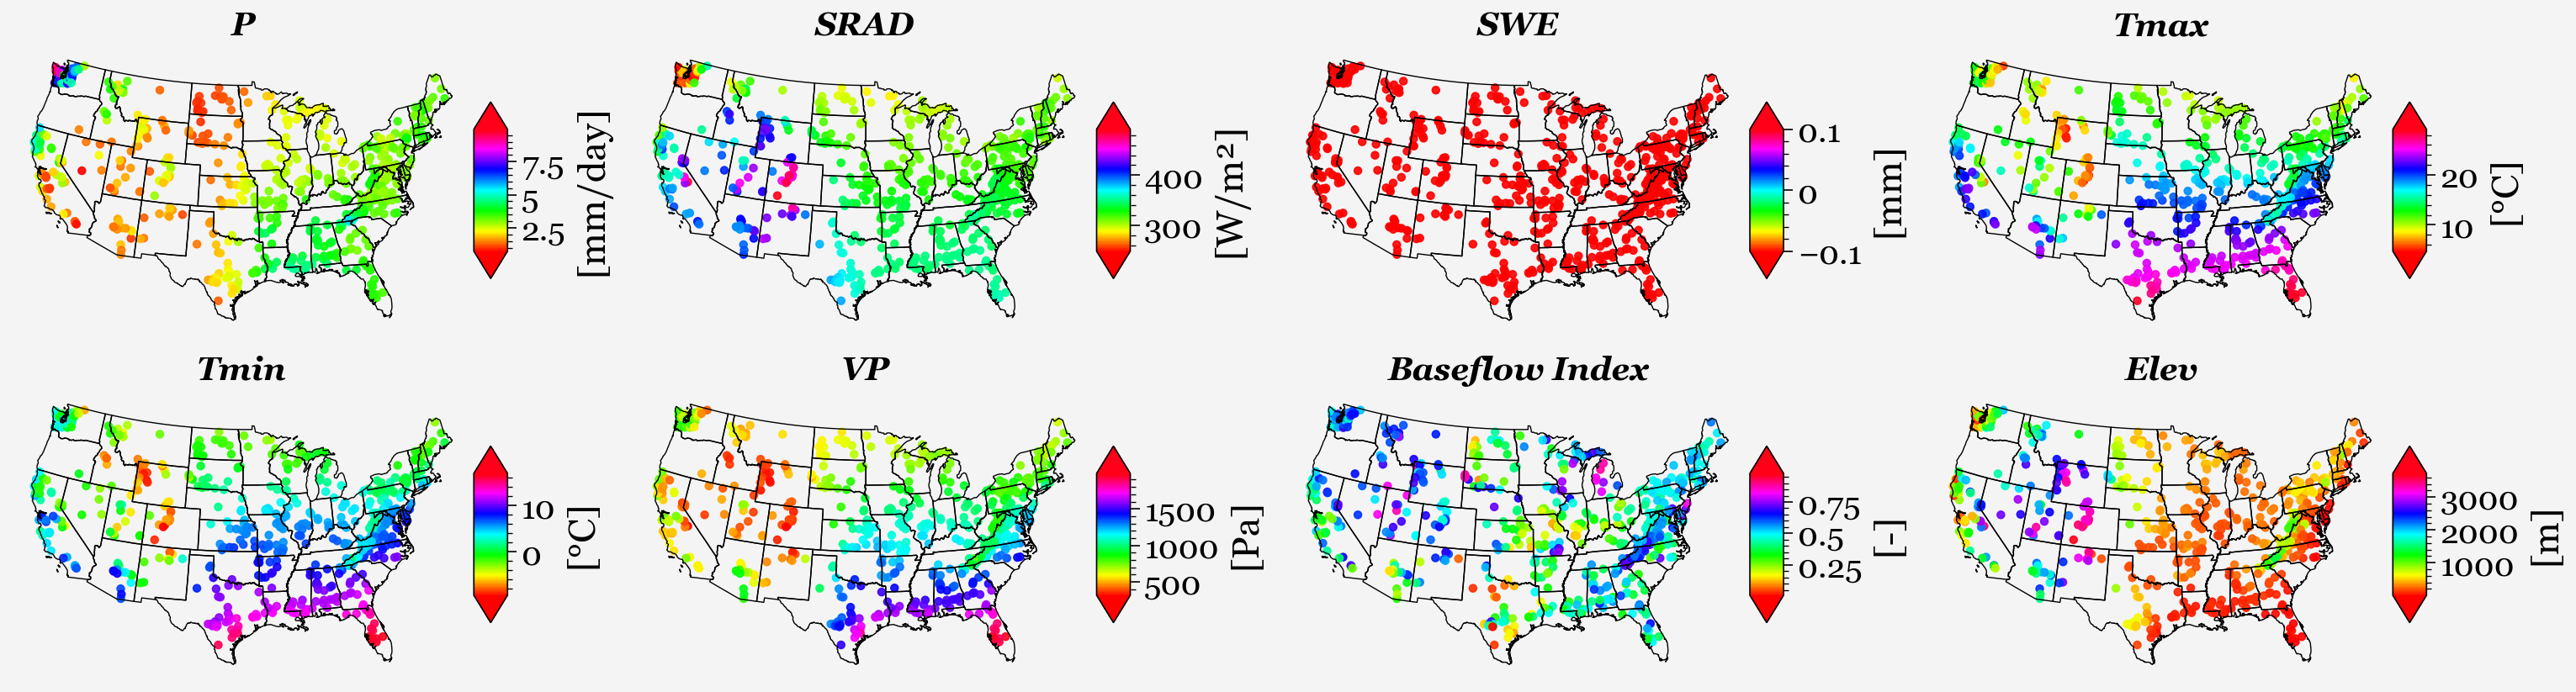

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt

plt.rcParams['font.family'] = 'Georgia'

columns_to_plot = [
    "prcp_mean", "srad_mean", "swe_mean",
    "tmax_mean", "tmin_mean", "vp_mean",
    "baseflow_index", "elev"
]

short_cols = [
    "P", "SRAD", "SWE",
    "Tmax", "Tmin", "VP",
    "Baseflow Index", "Elev"
]

units = [
    "[mm/day]", "[W/m²]", "[mm]",
    "[°C]", "[°C]", "[Pa]",
    "[-]", "[m]"
]

n = len(columns_to_plot)
ncols = 4
nrows = int(np.ceil(n / ncols))

fig, axs = pplt.subplots(
    nrows=nrows, ncols=ncols,
    refwidth='2.75in', refheight='1.75in',
    share=0
)

# ✅ FIX: ProPlot SubplotGrid -> make it a flat list
axs = list(axs)

for ax, column, short_col, unit in zip(axs, columns_to_plot, short_cols, units):

    states.boundary.to_crs(5070).plot(ax=ax, edgecolor='black', linewidth=0.5)

    CAMELS_LongTerm_Final_vars_all.to_crs(5070).plot(
        ax=ax,
        column=column,
        cmap='hsv',
        alpha=0.9,
        markersize=10,
        legend=False
    )

    sm = plt.cm.ScalarMappable(
        cmap='hsv',
        norm=plt.Normalize(
            vmin=CAMELS_LongTerm_Final_vars_all[column].min(),
            vmax=CAMELS_LongTerm_Final_vars_all[column].max()
        )
    )
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax, shrink=0.6, pad=0.03, aspect=40, extend='both')
    cbar.set_label(unit, fontsize=16)
    cbar.ax.tick_params(labelsize=14)

    ax.set_title(short_col, fontsize=14, fontweight='bold', fontstyle='italic')
    ax.set_axis_off()

# Turn off unused subplots
for ax in axs[len(columns_to_plot):]:
    ax.set_axis_off()

# fig.savefig("attrs_daymet_camels_longterm_vars_all.png", dpi=500, facecolor="white")

plt.tight_layout()
plt.show()
